<a href="https://colab.research.google.com/github/Ppangchon/project/blob/main/modelOCTtrans9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ModelOCT 

In [1]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import glob
import PIL
import plotly
import plotly.graph_objs as go
import pandas as pd
from numpy import array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, AveragePooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D)
import time
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
import requests
from IPython.display import Image
from io import BytesIO  
import pickle as p 
import plotly.graph_objs as go  
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
K.image_data_format()
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

## เตรียมชุดของข้อมูล

In [3]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์
path = '/content/drive/My Drive/focusOCT'  # data เราอยู่โฟล์เดอร์ไหน

In [5]:
batch_size = 8   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 256  # ความสูงของรูปภาพแต่ละรูป
img_width = 256   # ความกว้างของรูปภาพแต่ละรูป

num_classes = 4

## Train

In [6]:
# Train
train_dir = "/content/drive/My Drive/focusOCT/train"
train_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 468 images belonging to 4 classes.


In [7]:
print('Train')
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนภาพของคลาส

Train
[0 1 2 3]
[117 117 117 117]


In [8]:
train_set[0][0][0].shape   # W*H*3 (3 Channel RGB) 

(256, 256, 3)

## Validation

In [9]:
# Validation
val_dir ="/content/drive/My Drive/focusOCT/validation"
val_datagen = ImageDataGenerator(rescale = 1./255)

val_set = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 60 images belonging to 4 classes.


In [10]:
print('Validation')
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนข้อมูลของคลาส

Validation
[0 1 2 3]
[15 15 15 15]


## Test

In [11]:
# Test
test_dir ="/content/drive/My Drive/focusOCT/test"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(img_height, img_width))

Found 60 files belonging to 4 classes.


In [12]:
class_names = test_set.class_names
print(class_names)

['CSC', 'NORMAL', 'PCV', 'VKH']


## Setup และโหลด Dataset

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
target_img_shape = (256,256) 
train_dir = "/content/drive/My Drive/focusOCT/train" #train dir
val_dir = "/content/drive/My Drive/focusOCT/validation" #validation dir

In [15]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size = target_img_shape,
                                              batch_size = batch_size,
                                              class_mode = 'categorical')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_set = val_datagen.flow_from_directory(val_dir,
                                              target_size = target_img_shape,
                                              batch_size = batch_size,
                                              class_mode = 'categorical')

Found 468 images belonging to 4 classes.
Found 60 images belonging to 4 classes.


## Visualize

{'CSC': 0, 'NORMAL': 1, 'PCV': 2, 'VKH': 3}


(8, 256, 256, 3)
(8, 4)
class: [0. 1. 0. 0.]


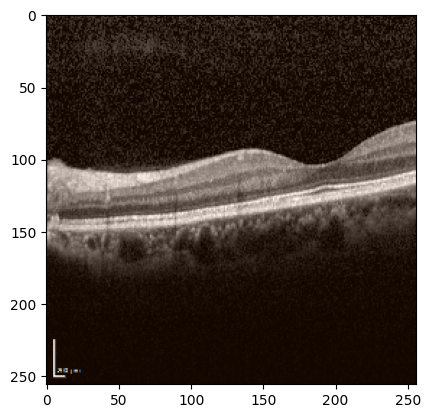

In [16]:
print(train_set.class_indices)
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)

  img = image_batch[0] - image_batch[0].min()
  img /= 255.0
  plt.imshow(img)
  print('class:', labels_batch[0])
  break

In [17]:
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

for i in ids:
  print('{:>8} = {}' . format(labels[i], counts[i]))

     CSC = 15
  NORMAL = 15
     PCV = 15
     VKH = 15


In [18]:
ids, counts = np.unique(val_set.classes, return_counts=True)   #ของ Validation
print(ids)
print(counts)

[0 1 2 3]
[15 15 15 15]


In [19]:
_, train_count = np.unique(train_set.classes, return_counts=True)
_, val_count = np.unique(val_set.classes, return_counts=True)

print('สัดส่วน Validation/Training set:', val_count/train_count*100)

สัดส่วน Validation/Training set: [12.82051282 12.82051282 12.82051282 12.82051282]


In [20]:
in_shape = (target_img_shape[0], target_img_shape[1],3)
in_shape

(256, 256, 3)

## สร้างโมเดล CNN

In [104]:
base_model = ResNet50(include_top = False,
                      weights='imagenet',        # Load weight
                      input_shape=in_shape)
model = Sequential()

model.add(base_model) # ตัวฐาน (Pre-trained)
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # เพิ่มชั้น 8
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu')) # เพิ่มชั้น 16

model.add(Dense(4, activation='softmax')) # 4 คลาส

model.summary() # ดูสรุป

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_9 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 40,399,108
Trainable params: 40,345,988


In [106]:
base_model.trainable = False # Freeze ส่วนที่เป็นฐาน (ResNet50)

In [107]:
print("Trainable..\n---")
for variable in model.trainable_variables:
  print(variable.name)

Trainable..
---
dense_9/kernel:0
dense_9/bias:0
dense_10/kernel:0
dense_10/bias:0
dense_11/kernel:0
dense_11/bias:0


ตรวจสอบด้วย .summary() อีกครั้งจะพบว่า Trainable ลดลงเท่ากับการ Freeze มีผลแล้ว

In [108]:
model.summary() # ดูสรุป

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_9 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 40,399,108
Trainable params: 16,811,396


### Compile และ Train

In [109]:
from tensorflow.keras.optimizers import Adam

In [110]:
from keras.api._v2.keras import callbacks
import time
model.compile(loss = 'categorical_crossentropy', 
              optimizer = Adam(lr=0.001), 
              metrics = ['accuracy'])

start = time.time()

history = model.fit(train_set,
                    validation_data=val_set, 
                    epochs=20,verbose=1)

end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/20
59/59 [==============================] - 109s 2s/step - loss: 16.1728 - accuracy: 0.4551 - val_loss: 1.9865 - val_accuracy: 0.5333
Epoch 2/20
59/59 [==============================] - 97s 2s/step - loss: 2.4747 - accuracy: 0.5534 - val_loss: 1.1207 - val_accuracy: 0.5333
Epoch 3/20
59/59 [==============================] - 95s 2s/step - loss: 1.2564 - accuracy: 0.4915 - val_loss: 1.3306 - val_accuracy: 0.5500
Epoch 4/20
59/59 [==============================] - 94s 2s/step - loss: 1.0122 - accuracy: 0.6197 - val_loss: 0.9840 - val_accuracy: 0.6333
Epoch 5/20
59/59 [==============================] - 96s 2s/step - loss: 0.9983 - accuracy: 0.6261 - val_loss: 0.8961 - val_accuracy: 0.6000
Epoch 6/20
59/59 [==============================] - 96s 2s/step - loss: 0.9141 - accuracy: 0.6111 - val_loss: 0.7348 - val_accuracy: 0.7333
Epoch 7/20
59/59 [==============================] - 95s 2s/step - loss: 0.8240 - accuracy: 0.6645 - val_loss: 0.8787 - val_accuracy: 0.7500
Epoch 8/20
59/59 [

### Save Model

In [137]:
modelOCT = '/Model'
if not os.path.exists(path+modelOCT):
    os.makedirs(path+modelOCT)
os.makedirs('/content/drive/My Drive/focusOCT/savemodel/', exist_ok=True)
model.save('/content/drive/MyDrive/focusOCT/savemodel/modelOCTtran9.h5')

with open('history_model', 'wb') as file:
   p.dump(history.history, file)

filepath='modelOCTtran9.h5'
model.save(filepath)
filepath_model = 'modelOCTtran9.json'
filepath_weights = 'weightsmodelOCTtran9.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weightsmodelOCTtran9.h5')
print("Saved model to disk")
     

Saved model to disk


### Load Model

In [116]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['val_accuracy'],
mode="lines", line=dict(
width=2,
color='blue'),
name="val_accuracy"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testOCT")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_9 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 40,399,108
Trainable params: 16,811,396


## ประเมิน

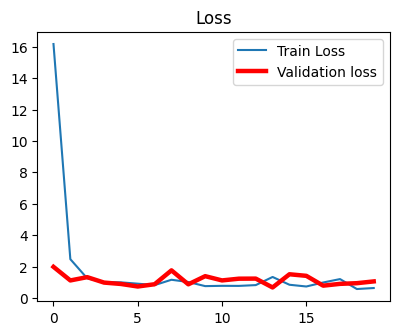

In [117]:
plt.figure(figsize = (10, 3.5))
plt.subplot(1, 2 , 1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], 'r', lw = 3.2, label = 'Validation loss')
plt.legend()

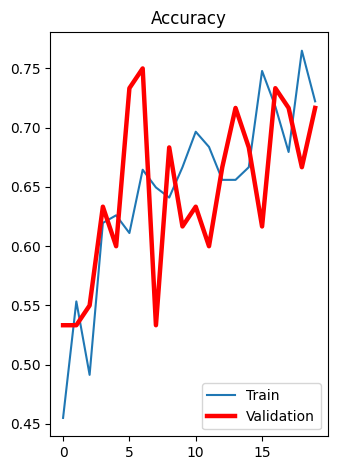

In [118]:
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], 'r', lw = 3.2, label = 'Validation')
plt.legend()
plt.tight_layout()
plt.show()

In [119]:
acc = model.evaluate(val_set, steps = len(val_set), verbose = 0)
print('score = {:.3f}' .format(acc[1]))

score = 0.717


### Prediction

In [72]:
import requests
from IPython.display import Image
from io import BytesIO
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing import image 
import keras.utils as image
from keras.models import load_model

In [32]:
train_set.class_indices

{'CSC': 0, 'NORMAL': 1, 'PCV': 2, 'VKH': 3}

1/1 [==============================] - 1s 550ms/step
CSC tf.Tensor(0.17489913, shape=(), dtype=float32) NORMAL tf.Tensor(0.17488265, shape=(), dtype=float32) PCV tf.Tensor(0.17488265, shape=(), dtype=float32) VKH tf.Tensor(0.4753355, shape=(), dtype=float32)


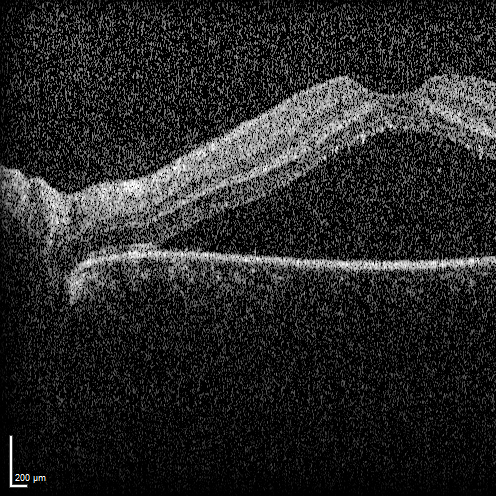

AI VKH มีความมั่นใจ 47.53%.


In [35]:
# CSC
test_path = ('/content/drive/My Drive/focusOCT/test/CSC/JS3524 29-01-18 LE_001_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"NORMAL",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "NORMAL"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 446ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) NORMAL tf.Tensor(0.47536692, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


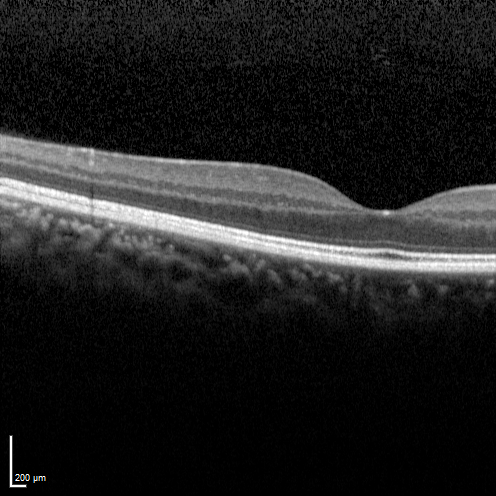

AI NORMAL มีความมั่นใจ 47.54%.


In [36]:
# NORMAL
test_path = ('/content/drive/My Drive/focusOCT/test/NORMAL/KJ5541 20-07-22 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"NORMAL",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "NORMAL"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 220ms/step
CSC tf.Tensor(0.1796713, shape=(), dtype=float32) NORMAL tf.Tensor(0.1796713, shape=(), dtype=float32) PCV tf.Tensor(0.1984292, shape=(), dtype=float32) VKH tf.Tensor(0.44222814, shape=(), dtype=float32)


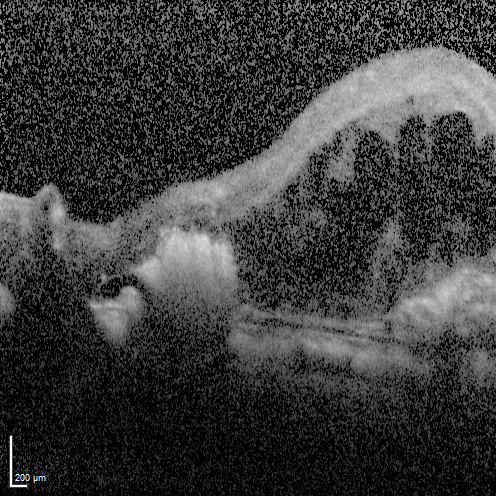

AI VKH มีความมั่นใจ 44.22%.


In [37]:
# PCV
test_path = ('/content/drive/My Drive/focusOCT/test/PCV/JU5423 01-08-18 LE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"NORMAL",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "NORMAL"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 1s 569ms/step
CSC tf.Tensor(0.1748777, shape=(), dtype=float32) NORMAL tf.Tensor(0.1748777, shape=(), dtype=float32) PCV tf.Tensor(0.1748777, shape=(), dtype=float32) VKH tf.Tensor(0.47536686, shape=(), dtype=float32)


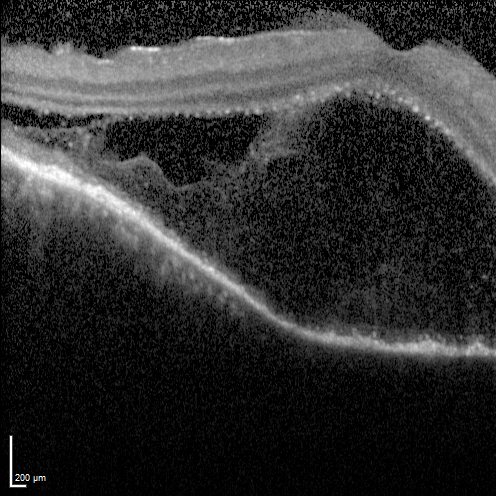

AI VKH มีความมั่นใจ 47.54%.


In [38]:
# VKH
test_path = ('/content/drive/My Drive/focusOCT/test/VKH/KB1074 25-09-19 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"NORMAL",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "NORMAL"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

### Testing

In [120]:
y_test = []; y_pred = []
class_names = test_set.class_names
for images, labels in test_set:
  for i in range(len(list(labels))):
    img_array = keras.preprocessing.image.img_to_array(images[i])
    X_test = tf.expand_dims(img_array, 0)
    score = predict_model.predict(X_test)
    if score[0][0]==np.max(score):
      eye = "CSC"
    elif score[0][1]==np.max(score):
      eye = "NORMAL"
    elif score[0][2]==np.max(score):
      eye = "PCV"
    elif score[0][3]==np.max(score):
      eye = "VKH"
    y_pred.append(eye)
    y_test.append(class_names[labels[i]])

1/1 [==============================] - 0s 181ms/step


In [121]:
print(y_test)
print(len(y_test))

['NORMAL', 'NORMAL', 'VKH', 'NORMAL', 'VKH', 'PCV', 'NORMAL', 'NORMAL', 'CSC', 'PCV', 'VKH', 'NORMAL', 'NORMAL', 'VKH', 'NORMAL', 'VKH', 'PCV', 'PCV', 'VKH', 'PCV', 'PCV', 'NORMAL', 'NORMAL', 'CSC', 'VKH', 'CSC', 'VKH', 'CSC', 'CSC', 'NORMAL', 'NORMAL', 'PCV', 'PCV', 'CSC', 'VKH', 'NORMAL', 'CSC', 'PCV', 'VKH', 'PCV', 'CSC', 'CSC', 'CSC', 'CSC', 'PCV', 'CSC', 'CSC', 'PCV', 'PCV', 'VKH', 'PCV', 'NORMAL', 'VKH', 'CSC', 'CSC', 'VKH', 'VKH', 'PCV', 'NORMAL', 'VKH']
60


In [122]:
print(y_pred)
print(len(y_pred))

['NORMAL', 'NORMAL', 'VKH', 'NORMAL', 'NORMAL', 'PCV', 'NORMAL', 'NORMAL', 'PCV', 'CSC', 'CSC', 'NORMAL', 'NORMAL', 'CSC', 'NORMAL', 'CSC', 'PCV', 'VKH', 'CSC', 'PCV', 'PCV', 'NORMAL', 'NORMAL', 'CSC', 'PCV', 'CSC', 'VKH', 'CSC', 'CSC', 'NORMAL', 'NORMAL', 'CSC', 'NORMAL', 'CSC', 'VKH', 'NORMAL', 'CSC', 'CSC', 'CSC', 'PCV', 'CSC', 'CSC', 'VKH', 'CSC', 'PCV', 'CSC', 'CSC', 'PCV', 'VKH', 'VKH', 'CSC', 'CSC', 'NORMAL', 'CSC', 'CSC', 'VKH', 'CSC', 'PCV', 'CSC', 'NORMAL']
60


## Confusion Matrix

In [123]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
confusion_matrix(y_test, y_pred)

array([[13,  0,  1,  1],
       [ 2, 13,  0,  0],
       [ 4,  1,  8,  2],
       [ 6,  3,  1,  5]])

In [125]:
cm = confusion_matrix(y_test, y_pred)

In [126]:
test_set.class_names

['CSC', 'NORMAL', 'PCV', 'VKH']

In [127]:
cm_df = pd.DataFrame(cm,
                     index = ['CSC', 'Normal', 'PCV', 'VKH'], 
                     columns = ['CSC', 'Normal', 'PCV', 'VKH'])

In [128]:
cm_df

,CSC,Normal,PCV,VKH
CSC,13,0,1,1
Normal,2,13,0,0
PCV,4,1,8,2
VKH,6,3,1,5


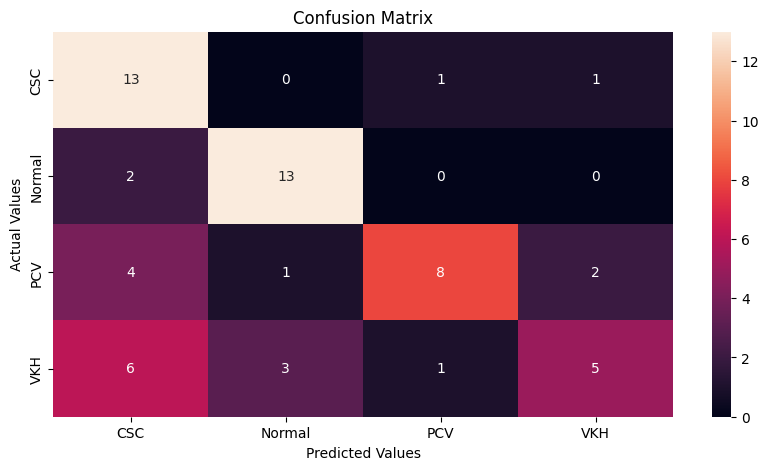

In [129]:
plt.figure(figsize=(10,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
     

## ตัวชี้วัด

In [130]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [131]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.650000


In [133]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Recall: %f' % recall)

Recall: 0.650000


In [134]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='macro') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Precision: %f' % precision)

Precision: 0.677426


In [135]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('F1 score: %f' % f1)

F1 score: 0.634321


##  misclassify

In [136]:
# แสดง misclassify ว่ามีกี่ค่า
misclassify = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:
            misclassify += cm[i][j]
            
print('misclassification: ', misclassify)

misclassification:  21


In [138]:
# คำนวณค่า misclassification
misclassify = 1 - np.trace(cm) / np.sum(cm)

# Misclassification rate = จำนวนภาพที่ถูกจัดหมวดหมู่ผิด / จำนวนภาพทั้งหมดที่ใช้ในการทดสอบ

# แสดงผลลัพธ์ที่คิดเป็น %
print("Misclassification: {:.2f}%".format(misclassify*100))

Misclassification: 35.00%


In [139]:
test_set_ = test_set.unbatch()

In [140]:
test_set.file_paths

['/content/drive/My Drive/focusOCT/test/VKH/KF0362 01-07-20 LE_001_cropped.png',
 '/content/drive/My Drive/focusOCT/test/VKH/KA3305 12-06-19 RE_000_cropped.png',
 '/content/drive/My Drive/focusOCT/test/CSC/JP8998 05-10-17 RE_000_cropped.png',
 '/content/drive/My Drive/focusOCT/test/NORMAL/KH4045 17-11-20 RE_000_cropped.png',
 '/content/drive/My Drive/focusOCT/test/PCV/JV1733 06-09-18 RE_000_cropped.png',
 '/content/drive/My Drive/focusOCT/test/VKH/KG1178 26-08-20 LE_001_cropped.png',
 '/content/drive/My Drive/focusOCT/test/NORMAL/KI5035 15-05-21 RE_000_cropped.png',
 '/content/drive/My Drive/focusOCT/test/CSC/JQ1338 26-09-17 LE_000_cropped.png',
 '/content/drive/My Drive/focusOCT/test/NORMAL/KI6700 21-07-21 LE_000_cropped.png',
 '/content/drive/My Drive/focusOCT/test/NORMAL/KC2883 07-11-19 LE_002_cropped.png',
 '/content/drive/My Drive/focusOCT/test/NORMAL/KE1051 11-08-20 LE_000_cropped.png',
 '/content/drive/My Drive/focusOCT/test/VKH/KD5863 21-10-20 RE_000_cropped.png',
 '/content/dr

In [141]:
import shutil

In [142]:
misclass_path = '/misclassify_model9'
if not os.path.exists(path+misclass_path):
    os.makedirs(path+misclass_path)

for myFilename in test_set.file_paths:

  tempfn = myFilename.split('/')
  myTrueVal = tempfn[6]
  mySubjID = tempfn[7].rstrip('_cropped.png')

  test_path = (myFilename)
  img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
    )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = predict_model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  if score[0]==np.max(score):
    eye = "CSC"
  elif score[1]==np.max(score):
    eye = "NORMAL"
  elif score[2]==np.max(score):
    eye = "PCV"
  elif score[3]==np.max(score):
    eye = "VKH"
  myConfid = np.round(100 * np.max(score),2)
  myPredVal = eye 

  if myTrueVal != myPredVal:
    fn = mySubjID+'__true-'+myTrueVal+'__pred-'+myPredVal+'__'+str(myConfid)+'.png'
    print(fn)
    shutil.copyfile(myFilename, path+misclass_path+'/'+fn)

1/1 [==============================] - 0s 175ms/step
KF0362 01-07-20 LE_001__true-VKH__pred-CSC__26.96.png
1/1 [==============================] - 0s 269ms/step
JP8998 05-10-17 RE_000__true-CSC__pred-VKH__27.61.png
1/1 [==============================] - 0s 333ms/step
JV1733 06-09-18 RE_000__true-PCV__pred-CSC__26.96.png
1/1 [==============================] - 1s 654ms/step
JQ1338 26-09-17 LE_000__true-CSC__pred-NORMAL__33.34.png
1/1 [==============================] - 0s 363ms/step
KI6700 21-07-21 LE_000__true-NORMAL__pred-CSC__26.96.png
1/1 [==============================] - 1s 581ms/step
KE1051 11-08-20 LE_000__true-NORMAL__pred-CSC__47.01.png
1/1 [==============================] - 0s 331ms/step
KD5863 21-10-20 RE_000__true-VKH__pred-CSC__26.96.png
1/1 [==============================] - 0s 327ms/step
JV0084 03-07-18 LE_000__true-PCV__pred-CSC__26.96.png
1/1 [==============================] - 0s 306ms/step
KA3347 12-06-19 LE_002__true-VKH__pred-NORMAL__38.42.png
1/1 [====================

In [143]:
myImages = list(test_set_.map(lambda x, y: x))
myLabels = list(test_set_.map(lambda x, y: y))

In [144]:
print(len(myImages),len(myLabels))

60 60
